<a href="https://colab.research.google.com/github/pontiac84/MLiS2car/blob/main/steering_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!git clone https://github.com/pontiac84/MLiS2car

fatal: destination path 'MLiS2car' already exists and is not an empty directory.


In [31]:
!ls MLiS2car

IMG			      README.md		   traffic_objects.py
objects_on_road_processor.py  steering_angles.csv


In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import random

In [33]:
datadir = 'MLiS2car'
columns = ['image_ID', 'angle', 'speed']
data = pd.read_csv(os.path.join(datadir, 'steering_angles.csv'), names = columns)
data.head()

,image_ID,angle,speed
0,1,0.4375,0.0
1,2,0.8125,1.0
2,3,0.4375,1.0
3,4,0.6250,1.0
4,5,0.5000,0.0


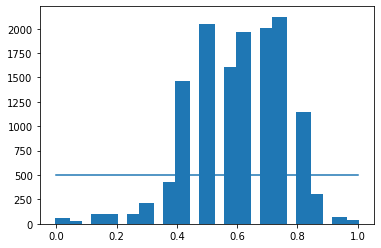

In [34]:
num_bins = 25
samples_per_bin = 500
hist, bins = np.histogram(data['angle'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['angle']), np.max(data['angle'])), (samples_per_bin, samples_per_bin))

In [35]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['angle'])):
    if data['angle'][i] >= bins[j] and data['angle'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
 
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

total data: 13793
removed: 8862
remaining: 4931


In [36]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  suffix = '.png'
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    image_ID = indexed_data[0]
    image_path.append(os.path.join(datadir, str(int(image_ID)) + suffix))
    steering.append(float(indexed_data[1]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [37]:
image_paths

array(['MLiS2car/IMG/2.png', 'MLiS2car/IMG/3.png', 'MLiS2car/IMG/4.png',
       ..., 'MLiS2car/IMG/13792.png', 'MLiS2car/IMG/13793.png',
       'MLiS2car/IMG/13798.png'], dtype='<U22')

In [38]:
steerings

array([0.8125, 0.4375, 0.625 , ..., 0.5625, 0.8125, 0.6875])

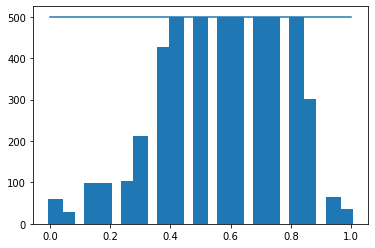

In [39]:
hist, _ = np.histogram(data['angle'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['angle']), np.max(data['angle'])), (samples_per_bin, samples_per_bin))

In [40]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 3944
Valid Samples: 987


Text(0.5, 1.0, 'Validation set')

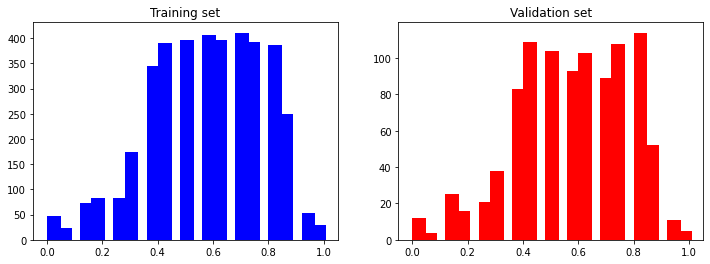

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

# Image Augmentation

In [42]:
def img_preprocess(img):
  img = mpimg.imread(img, cv2.IMREAD_COLOR)
  height = img.shape[0]
  img =  img[int(height/3):,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) 
  img = cv2.GaussianBlur(img,  (3, 3), 0)
  img = cv2.resize(img, (200, 66)) #input image size (200,66) Nvidia model
  img = img/255 # normalizing, the processed image becomes black for some reason.  do we need this?
  return img

Text(0.5, 1.0, 'Preprocessed Image')

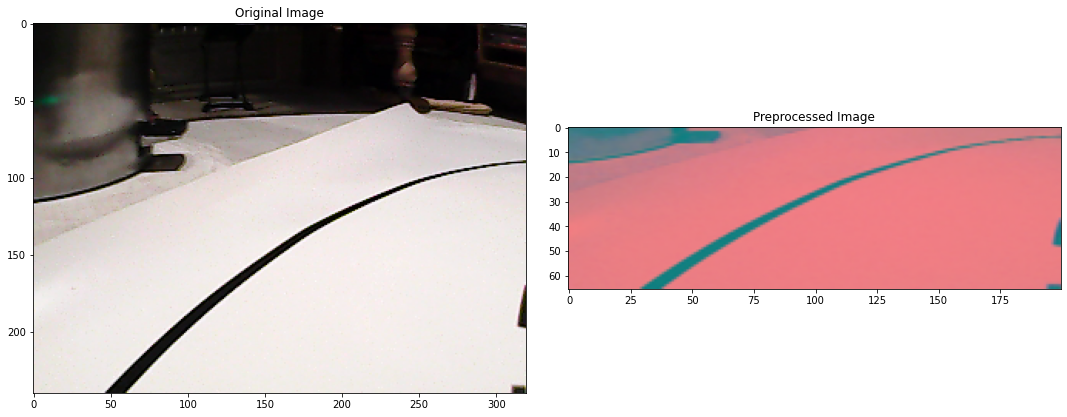

In [43]:
image = image_paths[121]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [44]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(3944, 66, 200, 3)


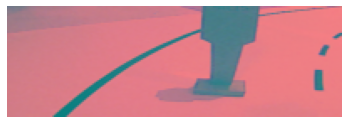

In [45]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

# Defining Nvidia Model


In [46]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Convolution2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(100, activation = 'elu'))
  model.add(Dropout(0.5))

  model.add(Dense(50, activation = 'elu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation = 'elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(1))

  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [47]:
model = nvidia_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)             

In [48]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)

Epoch 1/30
40/40 [==============================] - 3s 52ms/step - loss: 1.3746 - val_loss: 0.0562
Epoch 2/30
40/40 [==============================] - 2s 44ms/step - loss: 0.1496 - val_loss: 0.0557
Epoch 3/30
40/40 [==============================] - 2s 45ms/step - loss: 0.1183 - val_loss: 0.0460
Epoch 4/30
40/40 [==============================] - 2s 44ms/step - loss: 0.0969 - val_loss: 0.0478
Epoch 5/30
40/40 [==============================] - 2s 45ms/step - loss: 0.0917 - val_loss: 0.0402
Epoch 6/30
40/40 [==============================] - 2s 45ms/step - loss: 0.0853 - val_loss: 0.0378
Epoch 7/30
40/40 [==============================] - 2s 44ms/step - loss: 0.0753 - val_loss: 0.0383
Epoch 8/30
40/40 [==============================] - 2s 44ms/step - loss: 0.0760 - val_loss: 0.0407
Epoch 9/30
40/40 [==============================] - 2s 44ms/step - loss: 0.0735 - val_loss: 0.0365
Epoch 10/30
40/40 [==============================] - 2s 44ms/step - loss: 0.0646 - val_loss: 0.0387
Epoch 11/

Text(0.5, 0, 'Epoch')

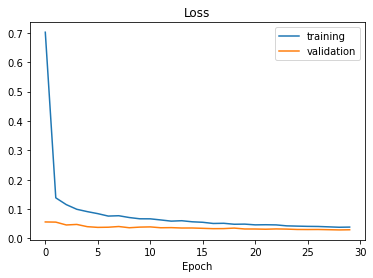

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [50]:
model.save('model.h5')

In [51]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Predict model

In [60]:
from keras.models import load_model
def predict_and_summarize(X, Y):
    model = load_model('model.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

predict_and_summarize(X_valid, y_valid)

mse       = 0.03
r_squared = 29.41%


array([[0.6416323 ],
       [0.7694951 ],
       [0.43739483],
       [0.61486375],
       [0.47564813],
       [0.6375418 ],
       [0.5576708 ],
       [0.59639657],
       [0.6080973 ],
       [0.50900257],
       [0.43031377],
       [0.66216457],
       [0.5052892 ],
       [0.5447564 ],
       [0.5251602 ],
       [0.70679855],
       [0.52177376],
       [0.48266768],
       [0.48480338],
       [0.6255505 ],
       [0.60758656],
       [0.6520833 ],
       [0.5907949 ],
       [0.6721451 ],
       [0.7194403 ],
       [0.650031  ],
       [0.54412043],
       [0.5233328 ],
       [0.5269575 ],
       [0.5906316 ],
       [0.6965296 ],
       [0.5243135 ],
       [0.5076345 ],
       [0.39113837],
       [0.54628694],
       [0.57152295],
       [0.5798918 ],
       [0.55836487],
       [0.54487795],
       [0.5930341 ],
       [0.59193236],
       [0.6311053 ],
       [0.70821524],
       [0.5249084 ],
       [0.47490802],
       [0.5561996 ],
       [0.6267794 ],
       [0.648